In [2]:
import pandas as pd
import matplotlib.pylab as plt

In [3]:
# 加载数据
file_path = '/Users/fanxinwei/Desktop/code/git_repo/dsmp-2024-group20/input_data/test_predictions_comparison(10).csv'
file_path_20 = '/Users/fanxinwei/Desktop/code/git_repo/dsmp-2024-group20/input_data/test_predictions_comparison(20).csv'
data = pd.read_csv(file_path)
data_20 = pd.read_csv(file_path_20)
# get Forecast of data_20 and insert it into data
data['Forecast_20'] = data_20['Forecast']
data.head(5)
# 0平稳1上升2下降

,time,Actual,Forecast,avg_price,Forecast_20
0,2025-05-27 16:28:10,0,0,134.750000,0
1,2025-05-27 16:28:11,0,0,133.714286,0
2,2025-05-27 16:28:12,0,0,132.250000,0
3,2025-05-27 16:28:13,0,0,130.650000,0
4,2025-05-27 16:28:14,0,0,132.961538,0


In [48]:
# get first 1000 rows and make it into 10 dataframes
data_list = []
periods = 10
for i in range(periods):
    data_list.append(data.iloc[i*100:(i+1)*100])

In [49]:
# 初始资金
initial_funds = 10000
# 资金
funds = initial_funds
# 股数
stocks = 0
# 买卖点
buy_sell_points = []

In [50]:
# 交易策略 
# 假设df是包含你数据的DataFrame
def trade_strategy(trade_data, funds, stocks, buy_sell_points):
    final_funds = 0
    profit = 0
    stocks_buy = 0
    stocks_sell = 0
    for index, row in trade_data.iterrows():
        forecast = row['Forecast']
        price = row['avg_price']
        
        if forecast == 1 and funds >= price*5:  # 有足够资金买入时
            # 买入一股股票
            stocks += 5
            funds -= price  # 更新剩余资金
            buy_sell_points.append((row['time'], 'buy'))
            stocks_buy+=5
        elif forecast == 2 and stocks > 0:  # 有股票可卖出时
            # 卖出一股股票
            stocks -= 5
            funds += price  # 更新资金
            buy_sell_points.append((row['time'], 'sell'))
            stocks_sell+=5
        else:
            buy_sell_points.append((row['time'], 'hold'))
        # 计算最终资金，考虑剩余的股票价值
    final_funds = funds + stocks * trade_data.iloc[-1]['avg_price']
    profit = final_funds - initial_funds  # 盈亏计算
    return final_funds, profit, stocks_buy, stocks_sell

In [51]:
avg_profit = 0
avg_final_funds = 0
total_buy = 0
total_sell = 0
for i in range(periods):
    final_funds,profit,stocks_buy,stocks_sell = trade_strategy(data_list[i], initial_funds, stocks, buy_sell_points)
    avg_profit += profit
    avg_final_funds += final_funds
    total_buy += stocks_buy
    total_sell += stocks_sell
    
avg_profit /= periods
avg_final_funds /= periods
print("Final funds: ${}".format(avg_final_funds))
print("Profit: ${}".format(avg_profit))
# compute the profit rate
profit_rate = avg_profit / initial_funds
print("Profit rate: {:.2%}".format(profit_rate))
# get how many times we buy and sell separately
buy_sell_points_df = pd.DataFrame(buy_sell_points, columns=['time', 'action'])
print(buy_sell_points_df['action'].value_counts()/periods)
print(f'sum_buy:{total_buy/periods}')
print(f'sum_sell:{total_sell/periods}')
print(avg_profit/(total_buy/periods))

Final funds: $14329.956806093589
Profit: $4329.956806093589
Profit rate: 43.30%
action
hold    51.3
buy     26.6
sell    22.1
Name: count, dtype: float64
sum_buy:133.0
sum_sell:110.5
32.55606621122999


In [52]:
trade_show = data_list[0]
# get second 100 rows of buy_sell_points
buy_sell_points_period = buy_sell_points_df.iloc[0:100]
trade_show['action'] = buy_sell_points_period['action']

/var/folders/90/3xy67qxj76v0lkc50q__s4t80000gn/T/ipykernel_43601/1372143231.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_show['action'] = buy_sell_points_period['action']


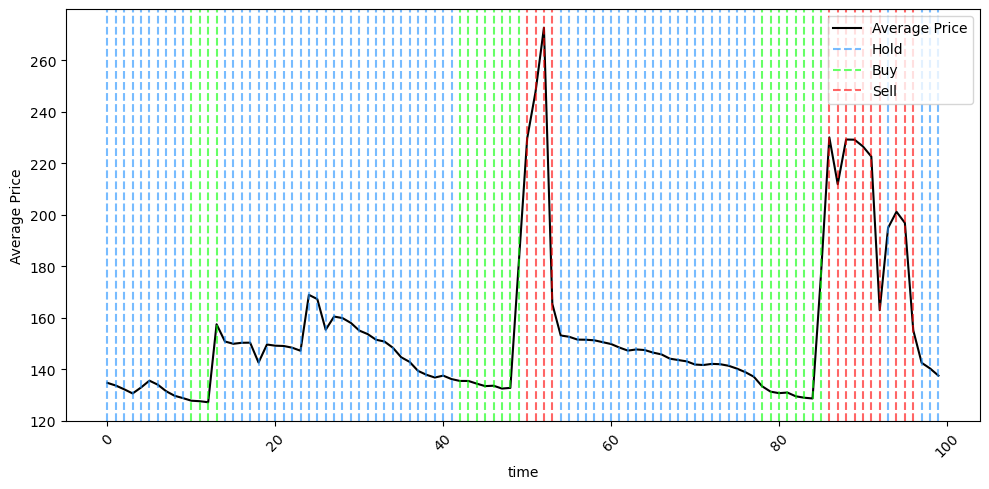

In [53]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制 avg_price
ax.plot(trade_show.index, trade_show['avg_price'], label='Average Price', color='black')

# 绘制不同action的竖线
for index, row in trade_show.iterrows():
    if row['action'] == 'buy':
        ax.axvline(x=index, color='lime', linestyle='--', alpha=0.6, label='Buy')
    elif row['action'] == 'sell':
        ax.axvline(x=index, color='r', linestyle='--', alpha=0.6, label='Sell')
    elif row['action'] == 'hold':
        ax.axvline(x=index, color='dodgerblue', linestyle='--', alpha=0.6, label='Hold')

# 设置图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# 设置标签和标题
ax.set_xlabel('time')
ax.set_ylabel('Average Price')

# 旋转X轴的标签
plt.xticks(rotation=45)

# 展示图表
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()

In [54]:
def trade_strategy_1020(trade_data, funds, stocks, buy_sell_points):
    stocks = 0
    stocks_buy = 0
    stocks_sell = 0
    for index, row in trade_data.iterrows():
        forecast = row['Forecast']
        price = row['avg_price']
        forecast20 = row['Forecast_20']
        
        if ((forecast == 0 and forecast20 == 0)) and funds >= price:
            buy_sell_points.append((row['time'], 'hold'))
        elif (forecast == 1 and forecast20 == 1):
            if funds >= 5 * price:
                stocks += 5
                stocks_buy += 5
                funds -= 5 * price  # 更新剩余资金
            buy_sell_points.append((row['time'], 'buy'))
        elif forecast == 2 and forecast20 == 2:  
            if stocks >= 5:
                stocks -= 5
                stocks_sell += 5
                funds += 5 * price  # 更新资金
            else:
                stocks_sell += stocks
                funds += stocks * price
                stocks = 0  
            buy_sell_points.append((row['time'], 'sell'))
        elif (forecast == 0 and forecast20 == 1):
            if funds >= 2 * price:
                stocks += 2
                stocks_buy += 2
                funds -= 2 * price  # 更新剩余资金
            buy_sell_points.append((row['time'], 'buy'))
        elif (forecast == 0 and forecast20 == 2):  
            if stocks >= 2:
                stocks -= 2
                stocks_sell += 2
                funds += 2 * price  # 更新资金
            else:
                stocks_sell += stocks
                funds += stocks * price
                stocks = 0
            buy_sell_points.append((row['time'], 'sell'))
        elif (((forecast == 1 and forecast20 == 0)
              or (forecast == 2 and forecast20 == 1)) and funds >= 1 * price):
            stocks += 1
            stocks_buy += 1
            funds -= 1 * price  # 更新资金
            buy_sell_points.append((row['time'], 'buy'))
        elif ((forecast == 2 and forecast20 == 0) 
              or (forecast == 1 and forecast20 == 2))  and stocks >= 1:  
            stocks -= 1
            stocks_sell += 1
            funds += 1 * price  # 更新资金
            buy_sell_points.append((row['time'], 'sell'))
        else:
            buy_sell_points.append((row['time'], 'hold'))

    # 计算最终资金，考虑剩余的股票价值
    final_funds = funds + stocks * trade_data.iloc[-1]['avg_price']
    profit = final_funds - initial_funds  # 盈亏计算
    return final_funds, profit, stocks_buy, stocks_sell

In [55]:
buy_sell_points = []
avg_profit = 0
avg_final_funds = 0
total_buy = 0
total_sell = 0
for i in range(periods):
    final_funds, profit,stocks_buy,stocks_sell = trade_strategy_1020(data_list[i], initial_funds, stocks, buy_sell_points)
    avg_profit += profit
    avg_final_funds += final_funds
    total_buy += stocks_buy
    total_sell += stocks_sell
avg_profit /= periods
avg_final_funds /= periods
print("Final funds: ${}".format(avg_final_funds))
print("Profit: ${}".format(avg_profit))
# compute the profit rate
profit_rate = avg_profit / initial_funds
print("Profit rate: {:.2%}".format(profit_rate))
buy_sell_points_df = pd.DataFrame(buy_sell_points, columns=['time', 'action'])
print(buy_sell_points_df['action'].value_counts()/periods)
print(f'sum_buy:{total_buy/periods}')
print(f'sum_sell:{total_sell/periods}')
print(avg_profit/(total_buy/periods))

Final funds: $17793.51553445737
Profit: $7793.515534457372
Profit rate: 77.94%
action
buy     37.9
hold    32.3
sell    29.8
Name: count, dtype: float64
sum_buy:143.5
sum_sell:105.0
54.31021278367507


In [56]:
# combine data_list 0 - 4
data_list_combine = pd.concat(data_list[0:1])
trade_show = data_list_combine
# get second 100 rows of buy_sell_points
buy_sell_points_period = buy_sell_points_df.iloc[0:101]
trade_show['action'] = buy_sell_points_period['action']

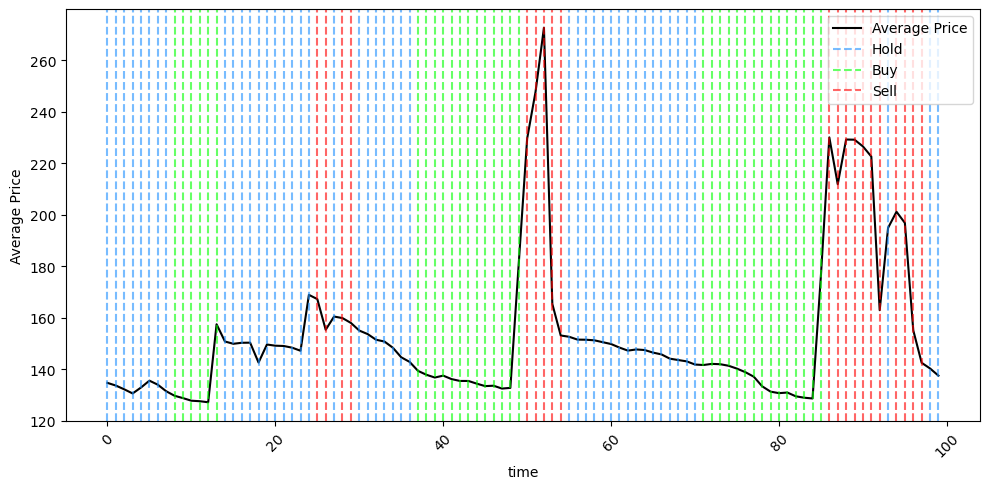

In [57]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制 avg_price
ax.plot(trade_show.index, trade_show['avg_price'], label='Average Price', color='black')

# 绘制不同action的竖线
for index, row in trade_show.iterrows():
    if row['action'] == 'buy':
        ax.axvline(x=index, color='lime', linestyle='--', alpha=0.6, label='Buy')
    elif row['action'] == 'sell':
        ax.axvline(x=index, color='r', linestyle='--', alpha=0.6, label='Sell')
    elif row['action'] == 'hold':
        ax.axvline(x=index, color='dodgerblue', linestyle='--', alpha=0.6, label='Hold')

# 设置图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# 设置标签和标题
ax.set_xlabel('time')
ax.set_ylabel('Average Price')

# 旋转X轴的标签
plt.xticks(rotation=45)

# 展示图表
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()

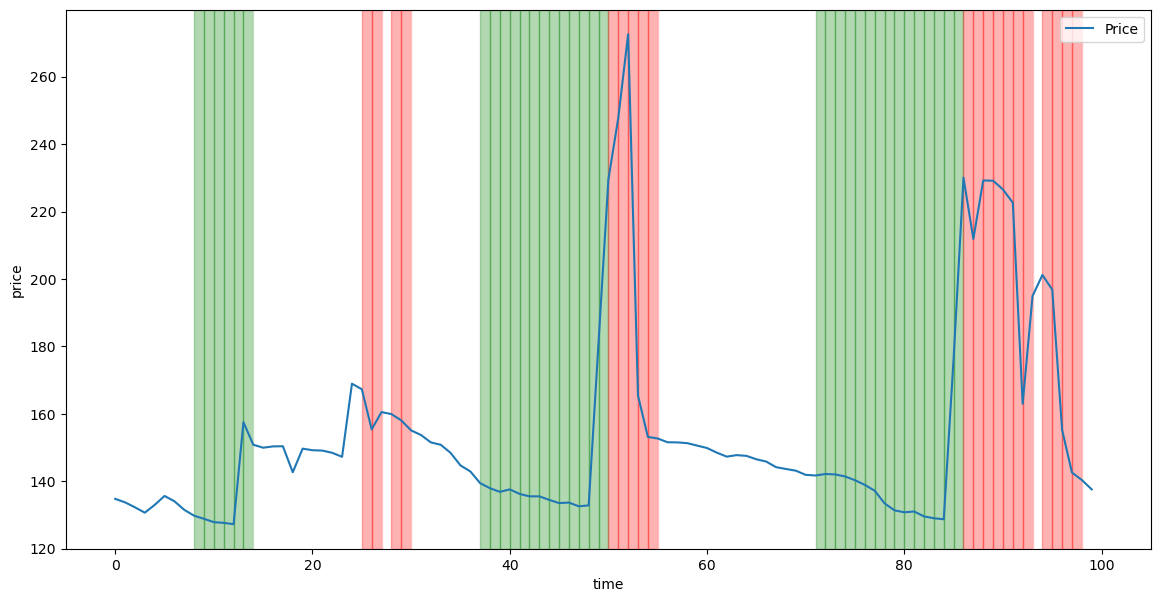

In [58]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 7))

# 绘制价格线
ax.plot(trade_show.index, trade_show['avg_price'], label='Price')

buy_patch = mpatches.Patch(color='green', alpha=0.3, label='Buy')
sell_patch = mpatches.Patch(color='red', alpha=0.3, label='Sell')
hold_patch = mpatches.Patch(color='white', alpha=0.3, label='Hold')

# 根据标签着色背景
for index, row in trade_show.iterrows():
    # 对于标签为0的数据点，不进行背景着色
    if row['action'] == 'buy':
        ax.axvspan(index, index+1,color='green', alpha=0.3)
    elif row['action'] == 'sell':
        ax.axvspan(index, index+1,color='red', alpha=0.3)
    elif row['action'] == 'hold':
        ax.axvspan(index, index+1,color='white',  alpha=0.3)

# 设置标题和坐标轴标签
ax.set_xlabel('time')
ax.set_ylabel('price')

ax.legend(handles=[buy_patch, sell_patch, hold_patch, ax.lines[0]], loc='upper right')

# 添加图例
ax.legend()
plt.savefig('price_trend.png')
# 显示图表
plt.show()